# ARIMA

## Data Engineering and Visualization

In [1]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
csv_files = glob.glob('*.csv')
csv_files

['EURGBP=X.csv',
 'GBPCHF=X.csv',
 'USDCHF=X.csv',
 'USDEUR=X.csv',
 'USDGBP=X.csv']

In [3]:
#personal preference
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv','EURGBP=X.csv', 'GBPCHF=X.csv']

In [4]:
df_train=[]
df_test=[]
for path in filepath:
    df_temp=pd.read_csv(path)
    #Since we need to make more profits, we only need the highest rate in a day.
    #We no longer need date, because we can use index.
    df_temp=df_temp[['High']]
    df_temp.columns=['rate']
    df_train.append(df_temp[:-5])
    df_test.append(df_temp[-5:])

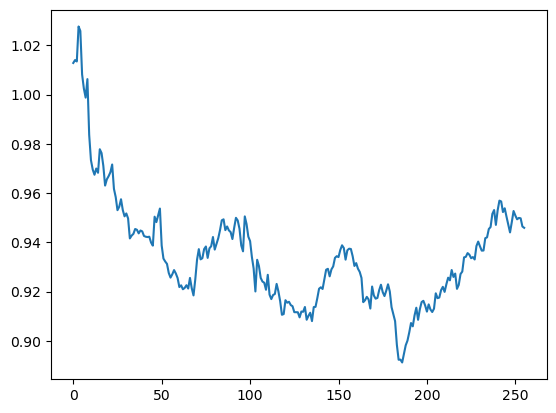

In [5]:
plt.plot(np.array(df_train[0].index),np.array(df_train[0])[:])

In [6]:
def test_stationarity(timeseries):
    # execute Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'p-value={dftest[1]}')

In [7]:
# First order difference is enough to make timeseries stationary, beacuase p-value<0.05. 
for i in range(5):
    print(f"{i}:")
    test_stationarity(df_train[i]['rate'])
    #test first-order difference
    test_stationarity(df_train[i]['rate'].diff().dropna())

0:
p-value=0.007889914649770222
p-value=1.8167772849784288e-22
1:
p-value=0.10403980362062754
p-value=7.352082609473927e-28
2:
p-value=0.3412277862184368
p-value=9.399249310172947e-05
3:
p-value=0.1828978826435067
p-value=4.151627301355065e-27
4:
p-value=0.15471964562418716
p-value=6.470678653881779e-17


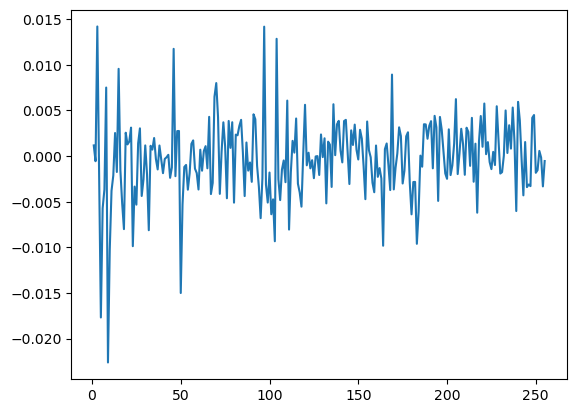

In [8]:
# By utilizing first order difference, we have made the timeseries stationary
plt.plot(df_train[0].diff().dropna())

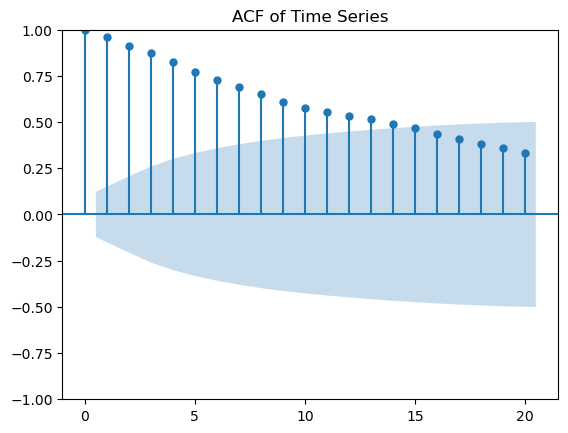

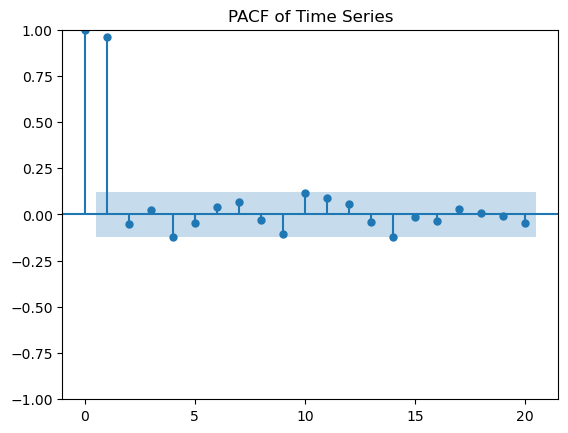

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot ACF figure
plot_acf(df_train[0], lags=20)
plt.title('ACF of Time Series')
plt.show()

# plot PACF figure
plot_pacf(df_train[0], lags=20)
plt.title('PACF of Time Series')
plt.show()

## Train ARIMA Model

In [10]:
#split train_dataset into train_dataset and validation_dataset, we set validation_dataset size to be 5, which conforms to test_dataset size
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [11]:
print(train.shape,val.shape)

(251,) (5,)


In [12]:
# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Since we have already applied difference on data, we set d=0 here.
p,d,q=1,2,1
model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 996.391
Date:                Tue, 31 Oct 2023   AIC                          -1986.783
Time:                        01:19:19   BIC                          -1976.230
Sample:                             0   HQIC                         -1982.535
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0289      0.055      0.521      0.602      -0.080       0.138
ma.L1         -0.9814      0.021    -47.673      0.000      -1.022      -0.941
sigma2       1.93e-05    1.1e-06     17.470      0.0

In [13]:
train

array([1.01281 , 1.01398 , 1.01342 , 1.02762 , 1.0258  , 1.00812 ,
       1.0024  , 0.99875 , 1.00626 , 0.98365 , 0.97337 , 0.96957 ,
       0.96745 , 0.96998 , 0.96824 , 0.9778  , 0.97624 , 0.97105 ,
       0.96305 , 0.96561 , 0.96689 , 0.96848 , 0.9716  , 0.96173 ,
       0.95839 , 0.95307 , 0.95447 , 0.95751 , 0.95314 , 0.95057 ,
       0.95174 , 0.94973 , 0.94161 , 0.94274 , 0.94345 , 0.94543 ,
       0.94512 , 0.94366 , 0.94482 , 0.94447 , 0.9426  , 0.94229 ,
       0.94216 , 0.9423  , 0.93992 , 0.93868 , 0.95043 , 0.94823 ,
       0.95097 , 0.95372 , 0.93872 , 0.93343 , 0.93224 , 0.93127 ,
       0.92759 , 0.9257  , 0.92704 , 0.92876 , 0.92739 , 0.92553 ,
       0.92187 , 0.92257 , 0.92097 , 0.92152 , 0.92261 , 0.92127 ,
       0.92557 , 0.92141 , 0.91847 , 0.92498 , 0.93298 , 0.93725 ,
       0.93311 , 0.93357 , 0.93727 , 0.93833 , 0.93371 , 0.93756 ,
       0.93846 , 0.94217 , 0.93707 , 0.93942 , 0.9417  , 0.945   ,
       0.94897 , 0.94935 , 0.94497 , 0.94646 , 0.94487 , 0.944

In [14]:
# prediction
train_predictions = result.predict(start=1, end=train.shape[0])
print(train_predictions)

val_predictions = result.get_forecast(len(val)).predicted_mean
print(val_predictions)

[1.519215   1.01515    1.01369985 1.03287896 1.02885001 1.00660556
 1.00053482 0.99669063 1.0057179  0.9797819  0.96921431 0.96563412
 0.9637155  0.96686808 0.9651043  0.97585409 0.97399745 0.96852441
 0.96012946 0.96329341 0.96472352 0.96650943 0.96991661 0.95929567
 0.95610434 0.95059774 0.95235155 0.95564485 0.95096376 0.94843097
 0.94983003 0.94772458 0.9392158  0.94073247 0.94152026 0.9436635
 0.94333348 0.94185038 0.94317648 0.94282149 0.94090107 0.9406762
 0.94059349 0.94078893 0.93831222 0.93711513 0.94959615 0.94695704
 0.94994417 0.95279145 0.93692141 0.9318244  0.93076319 0.92981198
 0.92599969 0.92415421 0.9256563  0.92746056 0.92599962 0.92411457
 0.92035089 0.92122755 0.91955526 0.92021159 0.92137078 0.91995833
 0.92454504 0.92007188 0.91713224 0.92408526 0.93231986 0.93658768
 0.93213056 0.932754   0.93664292 0.93766207 0.9327953  0.93698926
 0.93783452 0.94171527 0.93626511 0.93889507 0.94123034 0.94463657
 0.94871386 0.94900299 0.94440411 0.94610508 0.94440131 0.943722

In [15]:
val

array([0.94936, 0.94993, 0.94977, 0.94645, 0.94591])

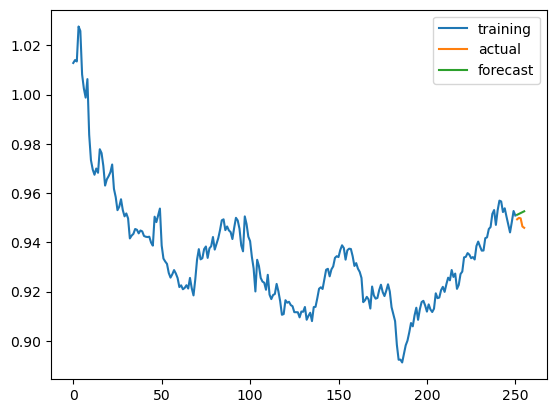

In [16]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

In [17]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_predictions,train)
val_mse = mean_squared_error(val_predictions, val)

print("train_MSE:", train_mse)
print("val_MSE:", val_mse)

train_MSE: 0.0010230408493949069
val_MSE: 1.784674493031853e-05


## Fine-tuning

In [18]:
#gird search
min_val_mse=1e9
optimal_p=1
optimal_d=1
optimal_q=1
for p in range(1,6):
    for d in range(1,3):
        for q in range(1,6):
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            train_predictions = result.predict(start=1, end=train.shape[0])
            val_predictions = result.get_forecast(len(val)).predicted_mean
            train_mse = mean_squared_error(train_predictions,train)
            val_mse = mean_squared_error(val_predictions, val)
            if (val_mse<min_val_mse):
                min_val_mse=val_mse
                optimal_p=p
                optimal_q=q
                optimal_d=d
            print(f"p={p},d={d},q={q}:")
            print("train_MSE:", train_mse)
            print("val_MSE:", val_mse)
            print("-------------------------------------------------------------")

p=1,d=1,q=1:
train_MSE: 6.07994557190068e-08
val_MSE: 9.26483235095815e-06
-------------------------------------------------------------
p=1,d=1,q=2:
train_MSE: 7.482017445128858e-08
val_MSE: 8.294398918910897e-06
-------------------------------------------------------------
p=1,d=1,q=3:
train_MSE: 2.0863021118603298e-07
val_MSE: 8.700248212292596e-06
-------------------------------------------------------------
p=1,d=1,q=4:
train_MSE: 1.8081545493028594e-07
val_MSE: 8.849308784093014e-06
-------------------------------------------------------------
p=1,d=1,q=5:
train_MSE: 7.815321661208432e-07
val_MSE: 7.633395514182213e-06
-------------------------------------------------------------
p=1,d=2,q=1:
train_MSE: 0.0010230408493949069
val_MSE: 1.784674493031853e-05
-------------------------------------------------------------
p=1,d=2,q=2:
train_MSE: 0.0010235643440533206
val_MSE: 1.8753168397332457e-05
-------------------------------------------------------------
p=1,d=2,q=3:
train_MSE: 0.

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=1,d=2,q=4:
train_MSE: 0.0010234022958963934
val_MSE: 1.659002186635543e-05
-------------------------------------------------------------
p=1,d=2,q=5:
train_MSE: 0.001023497297287576
val_MSE: 1.3498090672468804e-05
-------------------------------------------------------------
p=2,d=1,q=1:
train_MSE: 2.4842537873594735e-07
val_MSE: 7.947194831408128e-06
-------------------------------------------------------------
p=2,d=1,q=2:
train_MSE: 4.873250871318332e-07
val_MSE: 8.980576874050765e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=1,q=3:
train_MSE: 2.445703450686596e-07
val_MSE: 9.036843136083231e-06
-------------------------------------------------------------
p=2,d=1,q=4:
train_MSE: 2.1679933796112758e-07
val_MSE: 8.389924163878295e-06
-------------------------------------------------------------
p=2,d=1,q=5:
train_MSE: 7.018855977626831e-07
val_MSE: 6.619746693627365e-06
-------------------------------------------------------------
p=2,d=2,q=1:
train_MSE: 0.0010235826938337438
val_MSE: 1.5244484390254271e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=2,q=2:
train_MSE: 0.0010234823070911477
val_MSE: 2.3885924711597766e-05
-------------------------------------------------------------
p=2,d=2,q=3:
train_MSE: 0.001023267621329768
val_MSE: 2.083001346195514e-05
-------------------------------------------------------------
p=2,d=2,q=4:
train_MSE: 0.0010233448322444
val_MSE: 1.8756996238603475e-05
-------------------------------------------------------------
p=2,d=2,q=5:
train_MSE: 0.0010234968281790714
val_MSE: 1.3499675510974893e-05
-------------------------------------------------------------
p=3,d=1,q=1:
train_MSE: 2.487553849518791e-07
val_MSE: 7.954452215782679e-06
-------------------------------------------------------------
p=3,d=1,q=2:
train_MSE: 7.764980196400655e-08
val_MSE: 9.547007524613221e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=1,q=3:
train_MSE: 1.4763643364430836e-07
val_MSE: 8.388257554117829e-06
-------------------------------------------------------------
p=3,d=1,q=4:
train_MSE: 2.4354291330164225e-07
val_MSE: 8.268376611381649e-06
-------------------------------------------------------------
p=3,d=1,q=5:
train_MSE: 7.009644075439467e-07
val_MSE: 1.0956056804145304e-05
-------------------------------------------------------------
p=3,d=2,q=1:
train_MSE: 0.0010254907093686226
val_MSE: 8.479083822657347e-06
-------------------------------------------------------------
p=3,d=2,q=2:
train_MSE: 0.001024326923706146
val_MSE: 9.148801721846911e-06
-------------------------------------------------------------
p=3,d=2,q=3:
train_MSE: 0.0010233574765837069
val_MSE: 1.7714164189929163e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=4:
train_MSE: 0.0010246772921214836
val_MSE: 2.4699043427842128e-05
-------------------------------------------------------------
p=3,d=2,q=5:
train_MSE: 0.0010234786722427974
val_MSE: 1.922676782605745e-05
-------------------------------------------------------------
p=4,d=1,q=1:
train_MSE: 3.8935843353230544e-07
val_MSE: 8.843377849556454e-06
-------------------------------------------------------------
p=4,d=1,q=2:
train_MSE: 3.0676031124119066e-07
val_MSE: 9.038558210829689e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=1,q=3:
train_MSE: 1.7221020264239119e-07
val_MSE: 8.992210162648021e-06
-------------------------------------------------------------
p=4,d=1,q=4:
train_MSE: 6.684298218305703e-07
val_MSE: 8.861173973387454e-06
-------------------------------------------------------------
p=4,d=1,q=5:
train_MSE: 6.870377675195781e-07
val_MSE: 1.130833959762027e-05
-------------------------------------------------------------
p=4,d=2,q=1:
train_MSE: 0.0010256229223667228
val_MSE: 5.479631219588473e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=2:
train_MSE: 0.0010241375735415455
val_MSE: 1.0029402374024418e-05
-------------------------------------------------------------
p=4,d=2,q=3:
train_MSE: 0.0010236499471497338
val_MSE: 1.1688971177095087e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=4:
train_MSE: 0.0010246405516633483
val_MSE: 2.4146097158882016e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=2,q=5:
train_MSE: 0.0010232640531093972
val_MSE: 2.5776306492202943e-05
-------------------------------------------------------------
p=5,d=1,q=1:
train_MSE: 4.4858305585966785e-07
val_MSE: 1.0102145448167198e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=5,d=1,q=2:
train_MSE: 9.931885876465556e-07
val_MSE: 9.865693403891778e-06
-------------------------------------------------------------
p=5,d=1,q=3:
train_MSE: 1.101176751663566e-06
val_MSE: 1.0154418490598821e-05
-------------------------------------------------------------
p=5,d=1,q=4:
train_MSE: 1.1206236006915803e-06
val_MSE: 9.601094201414513e-06
-------------------------------------------------------------
p=5,d=1,q=5:
train_MSE: 7.27652558667309e-07
val_MSE: 1.0432110987798075e-05
-------------------------------------------------------------
p=5,d=2,q=1:
train_MSE: 0.0010256136750896492
val_MSE: 5.433181446516006e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=2,q=2:
train_MSE: 0.001024484170072524
val_MSE: 1.376128472514488e-05
-------------------------------------------------------------
p=5,d=2,q=3:
train_MSE: 0.0010255036468667387
val_MSE: 3.322612119790869e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=5,d=2,q=4:
train_MSE: 0.0010247572630739108
val_MSE: 2.5101900328553947e-05
-------------------------------------------------------------
p=5,d=2,q=5:
train_MSE: 0.0010237023152275039
val_MSE: 2.745215860931905e-05
-------------------------------------------------------------


In [19]:
print(optimal_p,optimal_d,optimal_q)

5 2 1


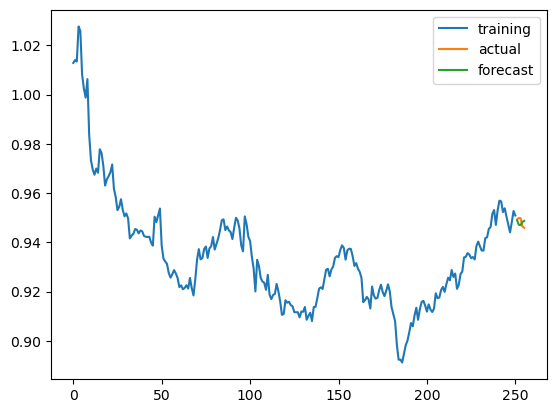

In [20]:
#visualize the best case
model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
result = model.fit()

train_predictions = result.predict(start=1, end=train.shape[0])
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Modularization

In [21]:
def fine_tune(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in range(1,6):
        for d in range(1,3):
            for q in range(1,6):
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                train_predictions = result.predict(start=1, end=train.shape[0])
                val_predictions = result.get_forecast(len(val)).predicted_mean
                train_mse = mean_squared_error(train_predictions,train)
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [22]:
#find best hyper parameters for each dataset
best_parameters=[]
for i in range(5):
    best_parameters.append(fine_tune(df_train[i]))

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting au

In [23]:
print(best_parameters)

[(5, 2, 1), (1, 2, 1), (4, 2, 2), (5, 2, 2), (1, 2, 2)]


In [24]:
def get_best_model(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

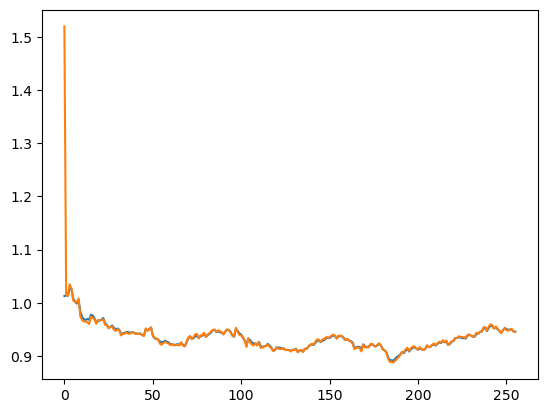

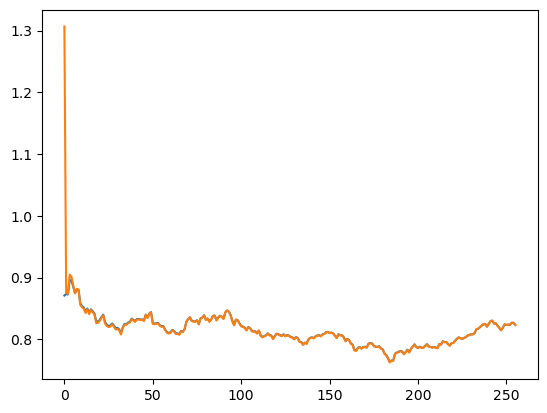

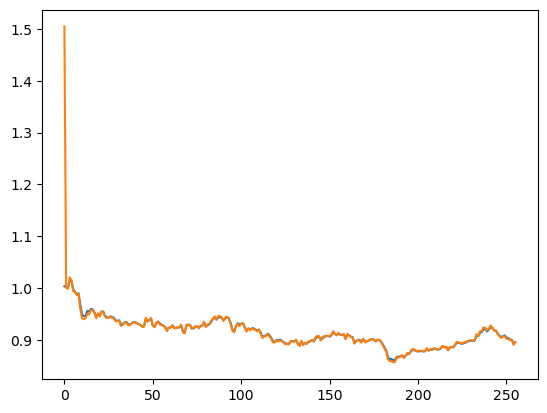

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


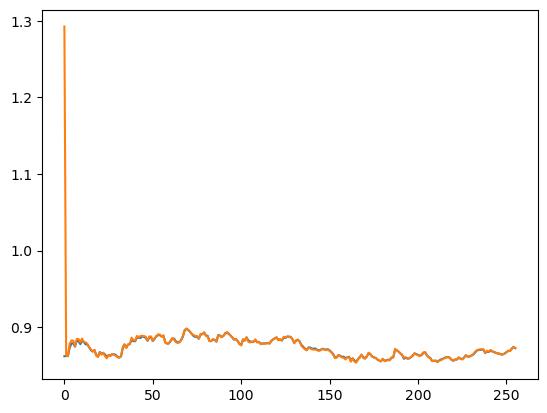

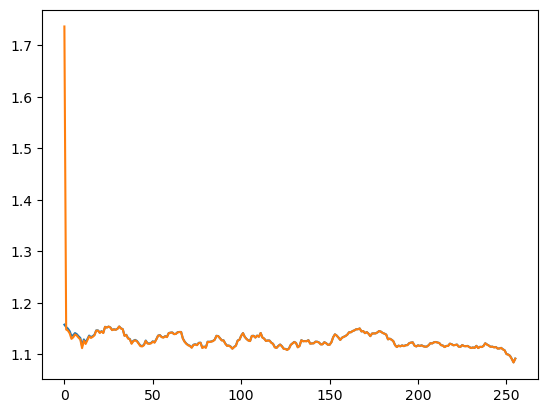

In [26]:
models=[]
for i in range(5):
    models.append(get_best_model(df_train[i],best_parameters[i]))

## Compute Max Profit

In [27]:
ARIMA_predictions=[]
for i in range(5):
    ARIMA_predictions.append(models[i].get_forecast(len(df_test[i])).predicted_mean)

In [28]:
ARIMA_predictions=np.array(ARIMA_predictions)
ARIMA_predictions

array([[0.94566366, 0.94544502, 0.94514888, 0.94407212, 0.94304909],
       [0.82337172, 0.82340072, 0.82343753, 0.82347472, 0.82351194],
       [0.89495314, 0.89307137, 0.89154314, 0.88930273, 0.88823428],
       [0.87262542, 0.87324026, 0.87336421, 0.87422415, 0.87522699],
       [1.09151301, 1.09122365, 1.09099306, 1.0907071 , 1.09047331]])

In [29]:
true_rate=[]
for i in range(5):
    true_rate.append(np.array(df_test[i]).squeeze())

In [30]:
true_rate=np.array(true_rate)
true_rate

array([[0.9448 , 0.94636, 0.95   , 0.9491 , 0.9478 ],
       [0.8224 , 0.82538, 0.82847, 0.826  , 0.82698],
       [0.8948 , 0.8964 , 0.89993, 0.9034 , 0.90486],
       [0.87111, 0.87257, 0.87338, 0.87204, 0.87405],
       [1.09399, 1.08814, 1.09009, 1.09696, 1.09745]])

In [31]:
def get_max_profit(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][-1])
        max_rate_increase=np.max(rate_increase)
        principal*=max_rate_increase
    return principal

In [32]:
predict_profit=get_max_profit(ARIMA_predictions)
true_profit=get_max_profit(true_rate)
print(predict_profit,true_profit)

1010.405189493407 1003.6959458896853


In [33]:
#Compute MSE between the max profit computed via ARIMA and the actual profit 
profit_mse = (predict_profit-true_profit)**2
print("MSE between the max profit computed via ARIMA and the actual profit is:", profit_mse)

MSE between the max profit computed via ARIMA and the actual profit is: 45.01394973408039
